In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics
#from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import statsmodels.api as sm
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.decomposition import PCA, FastICA
from scipy.stats import kurtosis
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

In [2]:
# file import and read - dataset 1
#==================================
#df = pd.read_csv(r"C:\Users\Shylu\Desktop\MS prep\2nd sem\ML\Assignment1\sgemm_product_dataset\sgemm_product.csv")
df_sgemm = pd.read_csv("sgemm_product.csv")
df_sgemm.describe()

# generate target variable as average of runs
df_sgemm['y']=(df_sgemm['Run1 (ms)']+df_sgemm['Run2 (ms)']+df_sgemm['Run3 (ms)']+df_sgemm['Run4 (ms)'])/4

#print(df['y'])
# remove extra fields in data set
df_sgemm.drop(['Run1 (ms)', 'Run2 (ms)','Run3 (ms)', 'Run4 (ms)'], axis=1, inplace=True)

In [3]:
# remove outliers above or below 3 standard deviations from mean
#=================================================================

df_sgemm = df_sgemm[~(np.abs(df_sgemm['y']-df_sgemm['y'].mean()) > (3*df_sgemm['y'].std()))] 
df_sgemm_orig = df_sgemm.copy()
df_sgemm

#236349 rows 

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,y
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,118.6625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,128,128,32,32,32,32,32,8,4,4,1,0,1,1,17.8175
241596,128,128,32,32,32,32,32,8,4,4,1,1,0,0,36.0350
241597,128,128,32,32,32,32,32,8,4,4,1,1,0,1,35.1600
241598,128,128,32,32,32,32,32,8,4,4,1,1,1,0,28.4525


In [4]:
# convert y to logistic
#========================
# df_sgemm['y'].mean()  = 175.549
#(df_sgemm['y'].apply(lambda x: 1 if x>175 else 0 ) ).sum() = 69707

cut_off = round(df_sgemm['y'].mean())
df_sgemm['y'] = df_sgemm['y'].apply(lambda x: 1 if x>cut_off else 0 ) 

# normalize dataset
#======================

cols_to_norm = ['MWG','NWG', 'KWG','MDIMC','NDIMC','MDIMA','NDIMB','KWI','VWM','VWN']
df_sgemm[cols_to_norm] = StandardScaler().fit_transform(df_sgemm[cols_to_norm])
df_sgemm

df_sgemm

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,y
0,-1.498672,-1.498506,-1.198399,-0.767081,-0.767081,-0.99866,-0.998592,-0.999065,-0.738004,-0.737814,0,0,0,0,0
1,-1.498672,-1.498506,-1.198399,-0.767081,-0.767081,-0.99866,-0.998592,-0.999065,-0.738004,-0.737814,0,0,0,1,0
2,-1.498672,-1.498506,-1.198399,-0.767081,-0.767081,-0.99866,-0.998592,-0.999065,-0.738004,-0.737814,0,0,1,0,0
3,-1.498672,-1.498506,-1.198399,-0.767081,-0.767081,-0.99866,-0.998592,-0.999065,-0.738004,-0.737814,0,0,1,1,0
4,-1.498672,-1.498506,-1.198399,-0.767081,-0.767081,-0.99866,-0.998592,-0.999065,-0.738004,-0.737814,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241595,1.141691,1.142262,0.834446,2.266972,2.266972,1.55808,1.558444,1.000935,0.810380,0.808556,1,0,1,1,0
241596,1.141691,1.142262,0.834446,2.266972,2.266972,1.55808,1.558444,1.000935,0.810380,0.808556,1,1,0,0,0
241597,1.141691,1.142262,0.834446,2.266972,2.266972,1.55808,1.558444,1.000935,0.810380,0.808556,1,1,0,1,0
241598,1.141691,1.142262,0.834446,2.266972,2.266972,1.55808,1.558444,1.000935,0.810380,0.808556,1,1,1,0,0


In [5]:
# split into train and test data set (70/30)
sgemm_train, sgemm_test = train_test_split(df_sgemm,train_size=0.7, test_size=0.3, random_state=0)

print(len(sgemm_train))
print(len(sgemm_test))

165444
70905


In [6]:
# file import and read - dataset 2
#==================================
#df = pd.read_csv(r"C:\Users\Shylu\Desktop\MS prep\2nd sem\ML\Assignment1\sgemm_product_dataset\sgemm_product.csv")
df_mush = pd.read_csv("mushrooms.csv")
print(df_mush.describe())

df_mush

       class cap-shape cap-surface cap-color bruises  odor gill-attachment  \
count   8124      8124        8124      8124    8124  8124            8124   
unique     2         6           4        10       2     9               2   
top        e         x           y         n       f     n               f   
freq    4208      3656        3244      2284    4748  3528            7914   

       gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
count          8124      8124       8124  ...                     8124   
unique            2         2         12  ...                        4   
top               c         b          b  ...                        s   
freq           6812      5612       1728  ...                     4936   

       stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
count                    8124                   8124      8124       8124   
unique                      9                      9         1          4   
top    

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [7]:
#imputing missing stalk-root values with most frequent value
#=============================================================

missing = (df_mush['stalk-root'].apply(lambda x:1 if x=='?' else 0)).sum()
print(missing)
print(df_mush['stalk-root'].value_counts())

df_mush = df_mush.replace('?',np.NaN)
print((df_mush['stalk-root'].isnull()).sum())

df_mush = df_mush.apply(lambda x: x.fillna(x.value_counts().index[0]))
#df_mush

print(df_mush['stalk-root'].value_counts())
print((df_mush['stalk-root'].isnull()).sum())

2480
b    3776
?    2480
e    1120
c     556
r     192
Name: stalk-root, dtype: int64
2480
b    6256
e    1120
c     556
r     192
Name: stalk-root, dtype: int64
0


In [8]:
#converting binary value columns into 0 and 1

df_mush['class'] = df_mush['class'].apply(lambda x: 1 if x=='p' else 0)
df_mush['bruises'] = df_mush['bruises'].apply(lambda x: 1 if x=='t' else 0)
df_mush['gill-attachment'] = df_mush['gill-attachment'].apply(lambda x: 1 if x=='a' else 0)
df_mush['gill-spacing'] = df_mush['gill-spacing'].apply(lambda x: 1 if x=='c' else 0)
df_mush['gill-size'] = df_mush['gill-size'].apply(lambda x: 1 if x=='b' else 0)
df_mush['stalk-shape'] = df_mush['stalk-shape'].apply(lambda x: 1 if x=='e' else 0)
df_mush['veil-type'] = df_mush['veil-type'].apply(lambda x: 1 if x=='p' else 0)

df_mush

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,x,s,n,1,p,0,1,0,k,...,s,w,w,1,w,o,p,k,s,u
1,0,x,s,y,1,a,0,1,1,k,...,s,w,w,1,w,o,p,n,n,g
2,0,b,s,w,1,l,0,1,1,n,...,s,w,w,1,w,o,p,n,n,m
3,1,x,y,w,1,p,0,1,0,n,...,s,w,w,1,w,o,p,k,s,u
4,0,x,s,g,0,n,0,0,1,k,...,s,w,w,1,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,k,s,n,0,n,1,1,1,y,...,s,o,o,1,o,o,p,b,c,l
8120,0,x,s,n,0,n,1,1,1,y,...,s,o,o,1,n,o,p,b,v,l
8121,0,f,s,n,0,n,1,1,1,n,...,s,o,o,1,o,o,p,b,c,l
8122,1,k,y,n,0,y,0,1,0,b,...,k,w,w,1,w,o,e,w,v,l


In [9]:
#columns with more than 2 values. Split and pivot them
df_mush_trans = pd.get_dummies(df_mush, prefix=['cap-shape', 'cap-surface', 'cap-color', 'odor', 'gill-color','stalk-root', 
                                            'stalk-surface-above-ring','stalk-surface-below-ring', 'stalk-color-above-ring',
                                            'stalk-color-below-ring', 'veil-color', 'ring-number','ring-type', 
                                            'spore-print-color', 'population', 'habitat'])
df_mush_trans

,class,bruises,gill-attachment,gill-spacing,gill-size,stalk-shape,veil-type,cap-shape_b,cap-shape_c,cap-shape_f,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,1,0,1,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,1,0,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,0,1,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8120,0,0,1,1,1,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
8121,0,0,1,1,1,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
8122,1,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [10]:
# split into train and test data set (70/30)
mush_train, mush_test = train_test_split(df_mush_trans,train_size=0.7, test_size=0.3, random_state=0)

print(len(mush_train))
print(len(mush_test))

5686
2438


In [11]:
def kmean(xtrain,ytrain,xtest, ytest, min_cluster, max_cluster): 
    sse = {}

    for k in range (min_cluster, max_cluster+1):
        kmean = KMeans(n_clusters=k, init='k-means++', random_state=0) 
        kmean.fit(xtrain) 
        
        # Predict 
        y_pred = kmean.predict(xtest)
        sse[k] = kmean.inertia_
        print("SSE for cluster {0} is {1}".format(k,sse[k]))
        
    plt.figure()
    plt.title("No. of clusters vs SSE")
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.show()    
        
   # centroids = kmean.cluster_centers_  
   # labels = kmean.labels_  
   # print("Centroids:\n",centroids)  
   # print("Labels: ",labels)
   # metrics.accuracy_score(ytest, y_pred)


In [12]:
def EM(xtrain, ytrain, xtest, ytest, min_cluster, max_cluster):
    arr_k=[]
    arr_ll = []
    
    for k in range (min_cluster, max_cluster+1):
        print("Number of clusters: {0}".format(k))
        gmm = GaussianMixture(n_components = k, random_state=0, covariance_type='full')
        gmm.fit(xtrain)
        labels = gmm.predict(xtest)
        print("Converged log-likelihood value is {0}".format(gmm.lower_bound_))
        print("No.of Iterations for log-likelihood to converge is {0}".format(gmm.n_iter_))
        arr_k.append(k)
        arr_ll.append(gmm.lower_bound_)
    
    n_components = np.arange(min_cluster, max_cluster)   
    models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(xtrain) for n in n_components]
        

    plt.plot(n_components, [m.bic(xtrain) for m in models], label='BIC')
    plt.plot(n_components, [m.aic(xtrain) for m in models], label='AIC')
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.show()
    
    xi = list(range(len(arr_k)))
    plt.title("No.of Clusters VS Log Likelihood")
    plt.xlabel("No.of Clusters")
    plt.ylabel("Log Likelihood")
    plt.plot(arr_ll, label = 'Log likelihood')
    plt.xticks(xi,arr_k)
    plt.legend()
    plt.show()

In [13]:
def fn_rfe(xtrain,ytrain,nof):
    # using recursive feature elimination

    cols = list(xtrain.columns)
    model = LogisticRegression(solver = 'lbfgs')

    #Initializing RFE model
    rfe = RFE(model, nof)             
    #Transforming data using RFE
    X_rfe = rfe.fit_transform(xtrain,ytrain)  
    #Fitting the data to model
    model.fit(X_rfe,ytrain)              
    temp = pd.Series(rfe.support_,index = cols)
    selected_features_rfe = temp[temp==True].index
    print(selected_features_rfe)

In [44]:
def ann(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test, nhidlayer, nneuron, activ_hidden,active_outer,hidlayerneuron):  
    model = Sequential()

    # 1st layer = input layer dimensions = no.of input cols
    # 2nd layer = 1st hidden layer = 11 neurons - assuming ((2/3)*(no.of input layer neurons))+no.of output layer neurons
    if hidlayerneuron==0:
        n_hidden_neuron = math.ceil(((2/3)*nneuron)+1)
    else: #user-defined number of hidden layer neurons
        n_hidden_neuron=hidlayerneuron
        
    print("No.of neurons in 1st hidden layer: {0}".format(n_hidden_neuron))
    model.add(Dense(n_hidden_neuron, input_dim=xtrain_train.shape[1], activation=activ_hidden)) 
    
    #adding subsequent hidden layers
    if nhidlayer>1:
        for i in range(1,nhidlayer):
            if hidlayerneuron==0:
                n_hidden_neuron=math.ceil(((2/3)*n_hidden_neuron)+1) #((2/3)*(no.of input layer neurons))+no.of output layer neurons
                print("No.of neurons in hidden layer {0}: {1}".format(i+1,n_hidden_neuron))
                model.add(Dense(n_hidden_neuron, activation=activ_hidden))  
            else: #user-defined number of hidden layer neurons
                n_hidden_neuron=hidlayerneuron #((2/3)*(no.of input layer neurons))+no.of output layer neurons
                print("No.of neurons in hidden layer {0}: {1}".format(i+1,n_hidden_neuron))
                model.add(Dense(n_hidden_neuron, activation=activ_hidden))   
                

    #output layer
    model.add(Dense(1, activation=active_outer)) 
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    
    model.fit(xtrain_train, ytrain_train, epochs=75, batch_size=20, verbose = 0) #, verbose = 1
    
    y_pred_in_sample = model.predict(xtrain_test) 
    y_pred_in_sample = y_pred_in_sample>0.5
    print ("In sample confusion matrix:")
    print(confusion_matrix(ytrain_test, y_pred_in_sample))
    
    y_pred_out_of_sample = model.predict(xtest_test)
    y_pred_out_of_sample = y_pred_out_of_sample>0.5
    print ("Out of sample confusion matrix:")
    print(confusion_matrix(ytest_test, y_pred_out_of_sample))
    
    _, accuracy_in_sample = model.evaluate(xtrain_test, ytrain_test, verbose=1)
    print('In Sample Accuracy: %.2f' % (accuracy_in_sample))  
    
    _, accuracy_out_sample = model.evaluate(xtest_test, ytest_test, verbose=1)
    print('Out of Sample Accuracy: %.2f' % (accuracy_out_sample))    

    return accuracy_in_sample, accuracy_out_sample
      

In [43]:
# cross validation
#==================
def cross_validation(xtrain,ytrain,xtest,ytest,fn_id,nfold=4,nhidlayer=1,nneuron=15, activ_hidden='relu',active_outer='sigmoid', hidlayerneuron=0, min_cluster=2, max_cluster=10 ):
    k=nfold
    i=0
    n_train=xtrain.shape[0]
    n_test=xtest.shape[0]
    accuracy_train= []
    accuracy_test = []
    sse = []
    
    for i in range(k):
        print("Cross validation iteration : {0}".format(i+1))
        xtrain_test = xtrain[int(i*n_train/k):int((i+1)*n_train/k)]
        ytrain_test = ytrain[int(i*n_train/k):int((i+1)*n_train/k)]
        xtest_test = xtest[int(i*n_test/k):int((i+1)*n_test/k)]
        ytest_test = ytest[int(i*n_test/k):int((i+1)*n_test/k)]
        
        xtrain_train_lower = xtrain[:int(i*n_train/k)]
        ytrain_train_lower = ytrain[:int(i*n_train/k)]

        xtrain_train_upper = xtrain[int((i+1)*n_train/k):]
        ytrain_train_upper = ytrain[int((i+1)*n_train/k):]
                
        xtrain_train = np.concatenate((xtrain_train_lower,xtrain_train_upper))
        ytrain_train = np.concatenate((ytrain_train_lower,ytrain_train_upper))
        
        if fn_id==1:  #
            acc_train, acc_test = ann(xtrain_train,ytrain_train, xtrain_test, ytrain_test,xtest_test, ytest_test,nhidlayer,nneuron,'relu','sigmoid',hidlayerneuron)

        accuracy_train.append(acc_train)
        accuracy_test.append(acc_test)
            
    return accuracy_train, accuracy_test #, cnf_matrix_train, cnf_matrix_test


In [15]:
# Dataset 1 = sgemm product 
#===========================
sgemm_train_x = sgemm_train[sgemm_train.columns.difference(['y'])]  # take all other columns except y
sgemm_train_y = sgemm_train['y']
sgemm_test_x = sgemm_test[sgemm_test.columns.difference(['y'])] 
sgemm_test_y = sgemm_test['y']

# Dataset 2 = mushroom
#======================
mush_train_x = mush_train[mush_train.columns.difference(['class'])]  # take all other columns except class
mush_train_y = mush_train['class']
mush_test_x = mush_test[mush_test.columns.difference(['class'])] 
mush_test_y = mush_test['class']

# K means clustering

SSE for cluster 2 is 1649815.4891999601
SSE for cluster 3 is 1519353.121963935
SSE for cluster 4 is 1406777.586153396
SSE for cluster 5 is 1304022.2909303862
SSE for cluster 6 is 1211560.6980322222
SSE for cluster 7 is 1146791.0450418687
SSE for cluster 8 is 1097562.551811029
SSE for cluster 9 is 1067990.3016811842
SSE for cluster 10 is 1039398.5857106117
SSE for cluster 11 is 1021811.4533893553
SSE for cluster 12 is 1003326.9812594801
SSE for cluster 13 is 979624.023899642
SSE for cluster 14 is 962014.4831103593
SSE for cluster 15 is 943509.9293015962


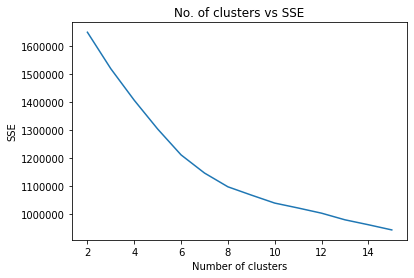

In [42]:
#Dataset 1 = sgemm product 
#==========================

kmean(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, min_cluster=2, max_cluster=15)


SSE for cluster 2 is 49467.79995575628
SSE for cluster 3 is 43129.86046879324
SSE for cluster 4 is 38664.74178319243
SSE for cluster 5 is 35516.5191242944
SSE for cluster 6 is 33349.441543591434
SSE for cluster 7 is 32020.49256426199
SSE for cluster 8 is 31418.220326947958
SSE for cluster 9 is 30359.82966751151
SSE for cluster 10 is 29137.2139675681
SSE for cluster 11 is 28507.653902086
SSE for cluster 12 is 27968.18444953585
SSE for cluster 13 is 27328.228870094525
SSE for cluster 14 is 26908.692222118112
SSE for cluster 15 is 26315.714872166882


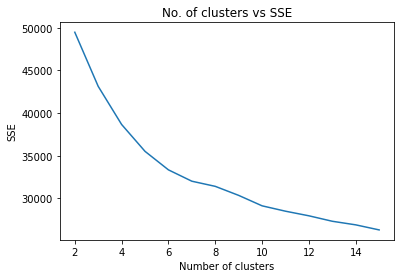

In [41]:
# Dataset 2 = mushroom
#======================

kmean(mush_train_x, mush_train_y, mush_test_x, mush_test_y, min_cluster=2, max_cluster=15)


# Expectation maximization

Number of clusters: 2
Converged log-likelihood value is -16.08601310992643
No.of Iterations for log-likelihood to converge is 2
Number of clusters: 3
Converged log-likelihood value is -15.765634245987265
No.of Iterations for log-likelihood to converge is 12
Number of clusters: 4
Converged log-likelihood value is -12.752297549841531
No.of Iterations for log-likelihood to converge is 7
Number of clusters: 5
Converged log-likelihood value is -13.119039991239427
No.of Iterations for log-likelihood to converge is 4
Number of clusters: 6
Converged log-likelihood value is -8.73710850138605
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 7
Converged log-likelihood value is -8.544076702690896
No.of Iterations for log-likelihood to converge is 12
Number of clusters: 8
Converged log-likelihood value is -4.914388707247566
No.of Iterations for log-likelihood to converge is 14
Number of clusters: 9
Converged log-likelihood value is -2.328766268384434
No.of Iterations for log

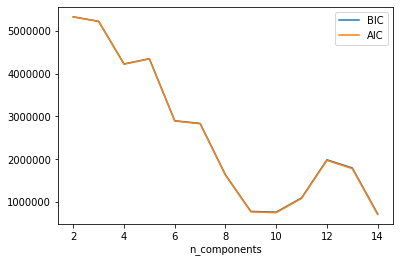

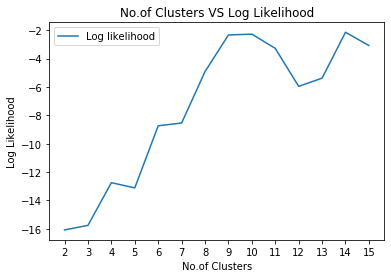

In [56]:
#Dataset 1 = sgemm product 
#==========================

EM(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_test_y, min_cluster=2, max_cluster=15)

Number of clusters: 2
Converged log-likelihood value is 335.67410948945087
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 3
Converged log-likelihood value is 370.2264490071119
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 4
Converged log-likelihood value is 406.8456052215865
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 5
Converged log-likelihood value is 476.53776360708844
No.of Iterations for log-likelihood to converge is 4
Number of clusters: 6
Converged log-likelihood value is 522.099910323838
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 7
Converged log-likelihood value is 527.914703891603
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 8
Converged log-likelihood value is 517.7333085751147
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 9
Converged log-likelihood value is 530.0159096964629
No.of Iterations for log-likelihood t

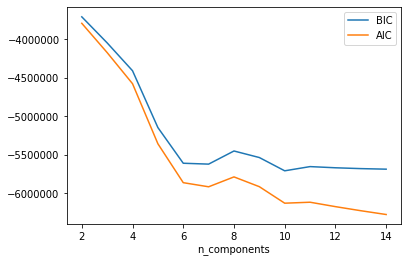

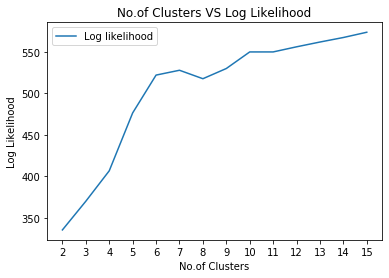

In [55]:
# Dataset 2 = mushroom
#======================

EM(mush_train_x, mush_train_y, mush_test_x, mush_test_y, min_cluster=2, max_cluster=15)


# Feature selection

### Decision Tree

Most important columns: Index(['MDIMC', 'MWG', 'NDIMC', 'NWG'], dtype='object')


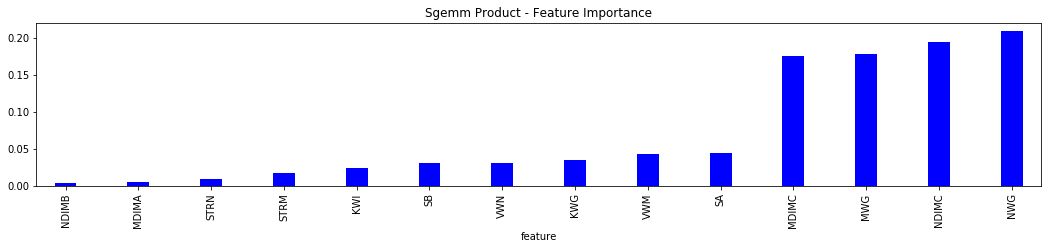

Most important columns: Index(['bruises', 'habitat_d', 'odor_n', 'spore-print-color_r', 'stalk-root_c',
       'stalk-surface-below-ring_y'],
      dtype='object')


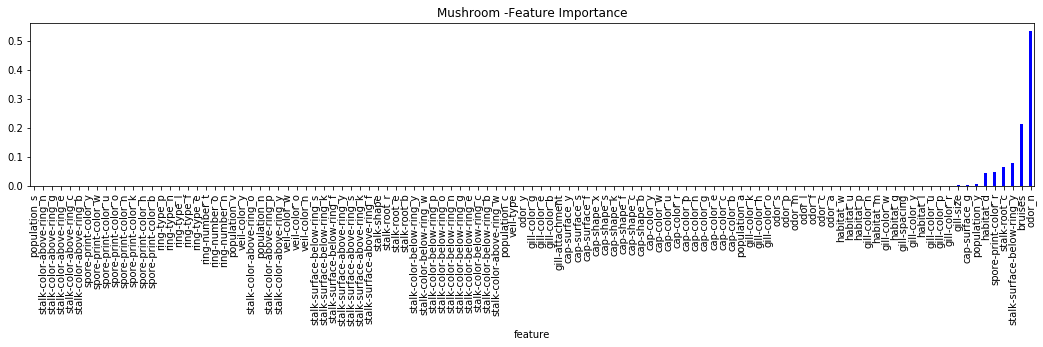

In [45]:
#Dataset 1 = sgemm product 
#==========================

dtree = DecisionTreeClassifier(random_state=0,criterion="entropy")
dtree.fit(sgemm_train_x,sgemm_train_y)

model = SelectFromModel(dtree, prefit=True) 
sgemm_train_x_transformed = model.transform(sgemm_train_x)
sgemm_test_x_transformed = model.transform(sgemm_test_x)
print("Most important columns:",sgemm_train_x.columns[model.get_support()])

features=pd.concat([pd.DataFrame(sgemm_train_x.columns),pd.DataFrame(dtree.feature_importances_)],axis=1)
features.columns=['feature','imp']
features.sort_values(by=['imp'],inplace=True)
features.set_index('feature',inplace=True)
plt.figure(figsize=(18,3))
features['imp'].plot.bar(width=0.3,color='b')
plt.title('Sgemm Product - Feature Importance')
plt.show()


# Dataset 2 = mushroom
#======================

dtree = DecisionTreeClassifier(random_state=0,criterion="entropy")
dtree.fit(mush_train_x,mush_train_y)

model = SelectFromModel(dtree, prefit=True) 
mush_train_x_transformed = model.transform(mush_train_x)
mush_test_x_transformed = model.transform(mush_test_x)
print("Most important columns:",mush_train_x.columns[model.get_support()])

features=pd.concat([pd.DataFrame(mush_train_x.columns),pd.DataFrame(dtree.feature_importances_)],axis=1)
features.columns=['feature','imp']
features.sort_values(by=['imp'],inplace=True)
features.set_index('feature',inplace=True)
plt.figure(figsize=(18,3))
features['imp'].plot.bar(width=0.3,color='b')
plt.title('Mushroom -Feature Importance')
plt.show()


### Using RFE - Recursive Feature Elimination

In [93]:
#Dataset 1 = sgemm product 
#==========================
# get optimal features using RFE - Recursive Feature Selection
fn_rfe(sgemm_train_x, sgemm_train_y, 4)

# Dataset 2 = mushroom
#======================
fn_rfe(mush_train_x, mush_train_y, 6)

Index(['MDIMC', 'MWG', 'NDIMC', 'NWG'], dtype='object')
Index(['odor_a', 'odor_f', 'odor_l', 'odor_n', 'spore-print-color_r',
       'stalk-color-below-ring_y'],
      dtype='object')


### Re-run clustering

Kmeans - Sgemm Product
SSE for cluster 2 is 514287.1462731345
SSE for cluster 3 is 397425.0319525831
SSE for cluster 4 is 294148.70816036017
SSE for cluster 5 is 227060.83423402367
SSE for cluster 6 is 185555.80605258618
SSE for cluster 7 is 166158.86645795073
SSE for cluster 8 is 154816.93815238125
SSE for cluster 9 is 138466.7301286515
SSE for cluster 10 is 128489.77878857234
SSE for cluster 11 is 122794.52688228342
SSE for cluster 12 is 115180.70196978381
SSE for cluster 13 is 109860.26468701001
SSE for cluster 14 is 99919.30733476678
SSE for cluster 15 is 93546.06271049276


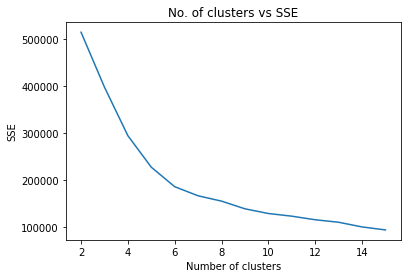

Kmeans - Mushroom
SSE for cluster 2 is 3022.660685474577
SSE for cluster 3 is 2113.2715806487236
SSE for cluster 4 is 1312.4920918975245
SSE for cluster 5 is 773.7320367383713
SSE for cluster 6 is 553.5022378225318
SSE for cluster 7 is 355.0638428572566
SSE for cluster 8 is 256.2785430506802
SSE for cluster 9 is 186.01950535590478
SSE for cluster 10 is 127.15611963802077
SSE for cluster 11 is 72.96049248036829
SSE for cluster 12 is 33.46934203789043
SSE for cluster 13 is 17.818548387096776
SSE for cluster 14 is 5.963488843813387
SSE for cluster 15 is 6.1903736526863305e-25


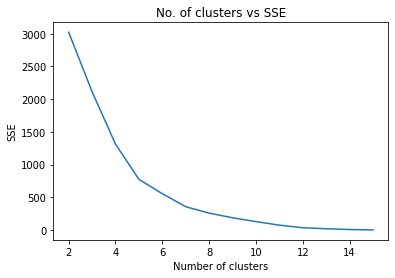

EM - Sgemm Product
Number of clusters: 2
Converged log-likelihood value is -4.41976032270003
No.of Iterations for log-likelihood to converge is 2
Number of clusters: 3
Converged log-likelihood value is -2.0718283096403924
No.of Iterations for log-likelihood to converge is 2
Number of clusters: 4
Converged log-likelihood value is -0.5686278468660224
No.of Iterations for log-likelihood to converge is 9
Number of clusters: 5
Converged log-likelihood value is -0.0721699164408725
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 6
Converged log-likelihood value is 0.9090875723571226
No.of Iterations for log-likelihood to converge is 6
Number of clusters: 7
Converged log-likelihood value is 1.1660063072812052
No.of Iterations for log-likelihood to converge is 6
Number of clusters: 8
Converged log-likelihood value is 2.627022395188104
No.of Iterations for log-likelihood to converge is 11
Number of clusters: 9
Converged log-likelihood value is 2.945781011310132
No.of Ite

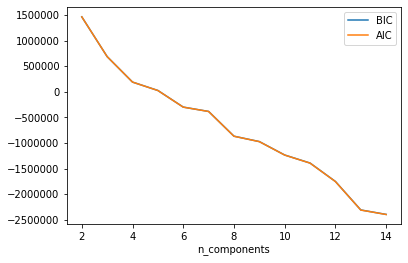

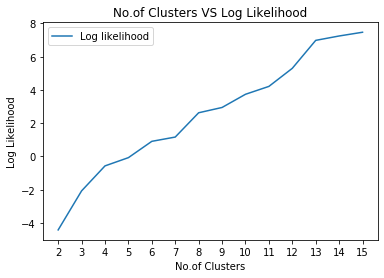

EM - Mushroom
Number of clusters: 2
Converged log-likelihood value is 11.145849681022627
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 3
Converged log-likelihood value is 16.11122946166848
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 4
Converged log-likelihood value is 17.70995228978772
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 5
Converged log-likelihood value is 21.349730379394625
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 6
Converged log-likelihood value is 25.062055726357787
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 7
Converged log-likelihood value is 25.809660372448135
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 8
Converged log-likelihood value is 28.15637250751003
No.of Iterations for log-likelihood to converge is 2
Number of clusters: 9
Converged log-likelihood value is 28.702836220266278
No.of Iterations f

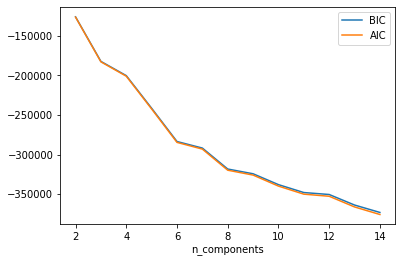

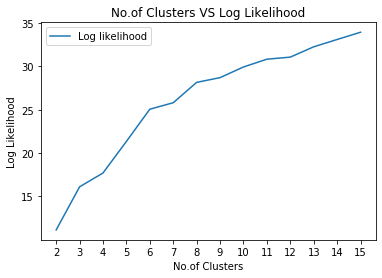

In [98]:
#Kmeans
#=======
print("Kmeans - Sgemm Product")
kmean(sgemm_train_x_transformed, sgemm_train_y, sgemm_test_x_transformed, sgemm_test_y, min_cluster=2, max_cluster=15)

print("Kmeans - Mushroom")
kmean(mush_train_x_transformed, mush_train_y, mush_test_x_transformed, mush_test_y, min_cluster=2, max_cluster=15)

#Expectation Maximization
#=========================
print("EM - Sgemm Product")
EM(sgemm_train_x_transformed, sgemm_train_y, sgemm_test_x_transformed, sgemm_test_y, min_cluster=2, max_cluster=15)

print("EM - Mushroom")
EM(mush_train_x_transformed, mush_train_y, mush_test_x_transformed, mush_test_y, min_cluster=2, max_cluster=15)

### Run Neural Networks

In [51]:
#Dataset 1 = sgemm product 
#==========================

sgemm_acc_train_dt, sgemm_cc_test_dt = cross_validation(sgemm_train_x_transformed, sgemm_train_y, sgemm_test_x_transformed, sgemm_test_y, 1,3, 1, sgemm_train_x_transformed.shape[1],'relu','sigmoid')

print("In Sample accuracy from ANN is {0}".format(sgemm_acc_train_dt))
print("Out of Sample accuracy from ANN is {0}".format(sgemm_cc_test_dt))
print(" ")
print("Average In Sample accuracy from ANN is {0}".format(statistics.mean(sgemm_acc_train_dt)))
print("Average Out of Sample accuracy from ANN is {0}".format(statistics.mean(sgemm_cc_test_dt)))



# Dataset 2 = mushroom
#======================

mush_acc_train_dt, mush_acc_test_dt = cross_validation(mush_train_x_transformed, mush_train_y, mush_test_x_transformed, mush_test_y, 1,3, 1, mush_train_x_transformed.shape[1],'relu','sigmoid')

print("In Sample accuracy from ANN is {0}".format(mush_acc_train_dt))
print("Out of Sample accuracy from ANN is {0}".format(mush_acc_test_dt))
print(" ")
print("Average In Sample accuracy from ANN is {0}".format(statistics.mean(mush_acc_train_dt)))
print("Average Out of Sample accuracy from ANN is {0}".format(statistics.mean(mush_acc_test_dt)))


Cross validation iteration : 1
No.of neurons in 1st hidden layer: 4
In sample confusion matrix:
[[36294  2617]
 [ 1619 14618]]
Out of sample confusion matrix:
[[15508  1097]
 [  757  6273]]
55148/55148 [==============================] - 2s 30us/step
In Sample Accuracy: 0.92
23635/23635 [==============================] - 1s 28us/step
Out of Sample Accuracy: 0.92
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 4
In sample confusion matrix:
[[37344  1680]
 [ 3272 12852]]
Out of sample confusion matrix:
[[16023   769]
 [ 1407  5436]]
55148/55148 [==============================] - 2s 31us/step
In Sample Accuracy: 0.91
23635/23635 [==============================] - 1s 31us/step
Out of Sample Accuracy: 0.91
Cross validation iteration : 3
No.of neurons in 1st hidden layer: 4
In sample confusion matrix:
[[35878  3069]
 [ 1028 15173]]
Out of sample confusion matrix:
[[15307  1346]
 [  502  6480]]
55148/55148 [==============================] - 5s 92us/step
In Sample Accuracy: 0.

# PCA

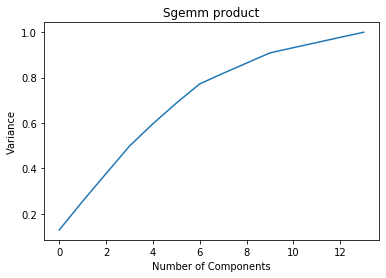

No.of features before transformation: 14
No.of features after transformation: 10


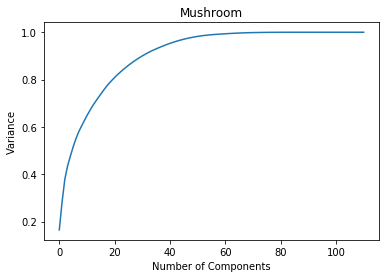

No.of features before transformation: 111
No.of features after transformation: 32


In [21]:
#Dataset 1 = sgemm product 
#==========================
pca = PCA().fit(sgemm_train_x)
plt.title('Sgemm product')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance')
plt.show()
pca = PCA(0.90).fit(sgemm_train_x)
sgemm_train_x_transformed_pca=pca.transform(sgemm_train_x)
sgemm_test_x_transformed_pca=pca.transform(sgemm_test_x)
print("No.of features before transformation: {0}".format(sgemm_train_x.shape[1]))
print("No.of features after transformation: {0}".format(sgemm_train_x_transformed_pca.shape[1]))


# Dataset 2 = mushroom
#======================
pca = PCA().fit(mush_train_x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Mushroom')
plt.xlabel('Number of Components')
plt.ylabel('Variance')
plt.show()
pca = PCA(0.90).fit(mush_train_x)
mush_train_x_transformed_pca=pca.transform(mush_train_x)
mush_test_x_transformed_pca=pca.transform(mush_test_x)
print("No.of features before transformation: {0}".format(mush_train_x.shape[1]))
print("No.of features after transformation: {0}".format(mush_train_x_transformed_pca.shape[1]))


### Rerun Clustering

Kmeans - Sgemm Product
SSE for cluster 2 is 1484503.729833289
SSE for cluster 3 is 1354056.9580713261
SSE for cluster 4 is 1241494.9734890333
SSE for cluster 5 is 1138714.1241767784
SSE for cluster 6 is 1046297.7468264018
SSE for cluster 7 is 981552.6561380125
SSE for cluster 8 is 939798.0686728637
SSE for cluster 9 is 900758.5410491973
SSE for cluster 10 is 879130.9619776548
SSE for cluster 11 is 848537.5919670551
SSE for cluster 12 is 833537.3525280793
SSE for cluster 13 is 818254.6600998199
SSE for cluster 14 is 797452.9001709325
SSE for cluster 15 is 776462.6099150992


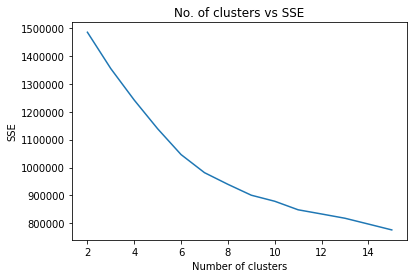

Kmeans - Mushroom
SSE for cluster 2 is 44034.22130984975
SSE for cluster 3 is 37702.53017233225
SSE for cluster 4 is 33246.56120019109
SSE for cluster 5 is 30107.93372669515
SSE for cluster 6 is 27952.689166276396
SSE for cluster 7 is 26654.23490695909
SSE for cluster 8 is 25660.903895036892
SSE for cluster 9 is 24589.66080947958
SSE for cluster 10 is 24036.356283455636
SSE for cluster 11 is 23333.729806239135
SSE for cluster 12 is 22586.218593318845
SSE for cluster 13 is 21922.155548044233
SSE for cluster 14 is 21838.089501524293
SSE for cluster 15 is 21237.358534614905


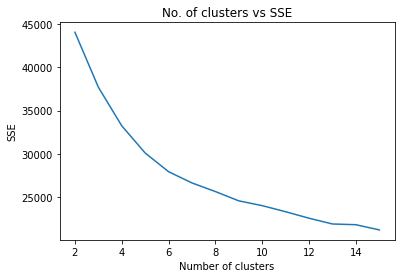

EM - Sgemm Product
Number of clusters: 2
Converged log-likelihood value is -13.1852457169039
No.of Iterations for log-likelihood to converge is 2
Number of clusters: 3
Converged log-likelihood value is -12.86559311014626
No.of Iterations for log-likelihood to converge is 12
Number of clusters: 4
Converged log-likelihood value is -11.09235102537389
No.of Iterations for log-likelihood to converge is 9
Number of clusters: 5
Converged log-likelihood value is -11.113878139817603
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 6
Converged log-likelihood value is -9.925461381799755
No.of Iterations for log-likelihood to converge is 8
Number of clusters: 7
Converged log-likelihood value is -9.32406485107374
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 8
Converged log-likelihood value is -7.585652759933484
No.of Iterations for log-likelihood to converge is 10
Number of clusters: 9
Converged log-likelihood value is -7.275565339677467
No.of Ite

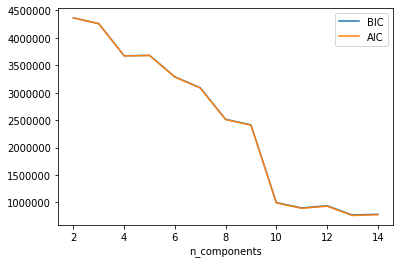

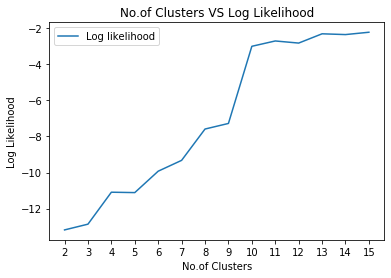

EM - Mushroom
Number of clusters: 2
Converged log-likelihood value is 2.57546947833804
No.of Iterations for log-likelihood to converge is 2
Number of clusters: 3
Converged log-likelihood value is 19.35933183072931
No.of Iterations for log-likelihood to converge is 4
Number of clusters: 4
Converged log-likelihood value is 53.72062822602079
No.of Iterations for log-likelihood to converge is 5
Number of clusters: 5
Converged log-likelihood value is 66.89206101300515
No.of Iterations for log-likelihood to converge is 5
Number of clusters: 6
Converged log-likelihood value is 77.14530455949476
No.of Iterations for log-likelihood to converge is 4
Number of clusters: 7
Converged log-likelihood value is 84.63978585721449
No.of Iterations for log-likelihood to converge is 5
Number of clusters: 8
Converged log-likelihood value is 79.80557269231456
No.of Iterations for log-likelihood to converge is 4
Number of clusters: 9
Converged log-likelihood value is 83.52569037861835
No.of Iterations for log

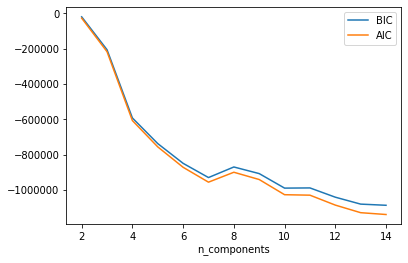

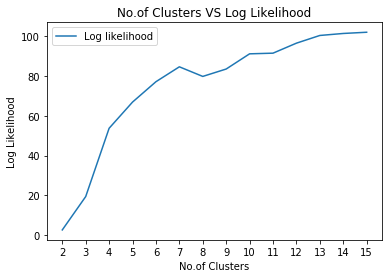

In [22]:
#Kmeans
#=======
print("Kmeans - Sgemm Product")
kmean(sgemm_train_x_transformed_pca, sgemm_train_y, sgemm_test_x_transformed_pca, sgemm_test_y, min_cluster=2, max_cluster=15)

print("Kmeans - Mushroom")
kmean(mush_train_x_transformed_pca, mush_train_y, mush_test_x_transformed_pca, mush_test_y, min_cluster=2, max_cluster=15)

#Expectation Maximization
#=========================
print("EM - Sgemm Product")
EM(sgemm_train_x_transformed_pca, sgemm_train_y, sgemm_test_x_transformed_pca, sgemm_test_y, min_cluster=2, max_cluster=15)

print("EM - Mushroom")
EM(mush_train_x_transformed_pca, mush_train_y, mush_test_x_transformed_pca, mush_test_y, min_cluster=2, max_cluster=15)

### Run Neural Networks

In [52]:
#Dataset 1 = sgemm product 
#==========================

sgemm_acc_train_pca, sgemm_cc_test_pca = cross_validation(sgemm_train_x_transformed_pca, sgemm_train_y, sgemm_test_x_transformed_pca, sgemm_test_y, 1,3, 1, sgemm_train_x_transformed_pca.shape[1],'relu','sigmoid')

print("In Sample accuracy from ANN is {0}".format(sgemm_acc_train_pca))
print("Out of Sample accuracy from ANN is {0}".format(sgemm_cc_test_pca))
print(" ")
print("Average In Sample accuracy from ANN is {0}".format(statistics.mean(sgemm_acc_train_pca)))
print("Average Out of Sample accuracy from ANN is {0}".format(statistics.mean(sgemm_cc_test_pca)))


# Dataset 2 = mushroom
#======================

mush_acc_train_pca, mush_acc_test_pca = cross_validation(mush_train_x_transformed_pca, mush_train_y, mush_test_x_transformed_pca, mush_test_y, 1,3, 1, mush_train_x_transformed_pca.shape[1],'relu','sigmoid')

print("In Sample accuracy from ANN is {0}".format(mush_acc_train_pca))
print("Out of Sample accuracy from ANN is {0}".format(mush_acc_test_pca))
print(" ")
print("Average In Sample accuracy from ANN is {0}".format(statistics.mean(mush_acc_train_pca)))
print("Average Out of Sample accuracy from ANN is {0}".format(statistics.mean(mush_acc_test_pca)))

Cross validation iteration : 1
No.of neurons in 1st hidden layer: 8
In sample confusion matrix:
[[37241  1670]
 [ 1045 15192]]
Out of sample confusion matrix:
[[15905   700]
 [  484  6546]]
55148/55148 [==============================] - 2s 32us/step
In Sample Accuracy: 0.95
23635/23635 [==============================] - 1s 33us/step
Out of Sample Accuracy: 0.95
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 8
In sample confusion matrix:
[[37421  1603]
 [ 1133 14991]]
Out of sample confusion matrix:
[[16047   745]
 [  460  6383]]
55148/55148 [==============================] - 2s 31us/step
In Sample Accuracy: 0.95
23635/23635 [==============================] - 1s 32us/step
Out of Sample Accuracy: 0.95
Cross validation iteration : 3
No.of neurons in 1st hidden layer: 8
In sample confusion matrix:
[[36857  2090]
 [  989 15212]]
Out of sample confusion matrix:
[[15702   951]
 [  442  6540]]
55148/55148 [==============================] - 2s 31us/step
In Sample Accuracy: 0.

# ICA

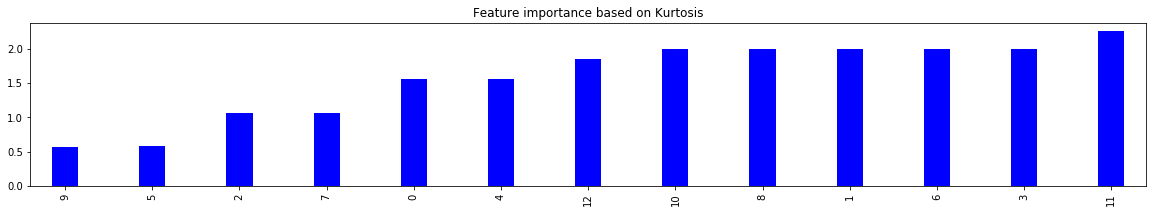

No.of features before transformation: 14
No.of features after transformation: 2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


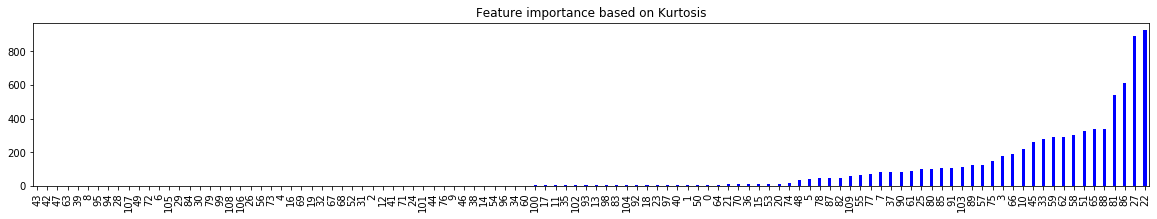

No.of features before transformation: 111
No.of features after transformation: 11


In [37]:
#Dataset 1 = sgemm product 
#==========================
ica = FastICA(random_state=0)
sgemm_train_x_transformed_ica = ica.fit_transform(sgemm_train_x)
sgemm_test_x_transformed_ica = ica.fit_transform(sgemm_test_x)
k,index=[],[]

for i in range(1, sgemm_train_x_transformed_ica.shape[1]):
    k.append(abs(kurtosis(sgemm_train_x_transformed_ica[:,i], fisher=True)))
    index.append(i)

ica_data=pd.DataFrame(k,index)
ica_data.reset_index(inplace=True)
ica_data.columns=['index','kurtosis']
ica_data=ica_data.sort_values(['kurtosis'],ascending=[1])
plt.figure(figsize=(20, 3))
ica_data['kurtosis'].plot.bar(width=0.3,color='b')
plt.title('Feature importance based on Kurtosis')
plt.show()
sgemm_train_x_transformed_ica=sgemm_train_x_transformed_ica[:,ica_data[ica_data['kurtosis']<=1]['index']]
sgemm_test_x_transformed_ica=sgemm_test_x_transformed_ica[:,ica_data[ica_data['kurtosis']<=1]['index']]
print("No.of features before transformation: {0}".format(sgemm_train_x.shape[1]))
print("No.of features after transformation: {0}".format(sgemm_train_x_transformed_ica.shape[1]))


# Dataset 2 = mushroom
#======================
ica = FastICA(random_state=0)
mush_train_x_transformed_ica = ica.fit_transform(mush_train_x)
mush_test_x_transformed_ica = ica.fit_transform(mush_test_x)
k,index=[],[]

for i in range(1, mush_train_x_transformed_ica.shape[1]):
    k.append(abs(kurtosis(mush_train_x_transformed_ica[:,i], fisher=True)))
    index.append(i)

ica_data=pd.DataFrame(k,index)
ica_data.reset_index(inplace=True)
ica_data.columns=['index','kurtosis']
ica_data=ica_data.sort_values(['kurtosis'],ascending=[1])
plt.figure(figsize=(20, 3))
ica_data['kurtosis'].plot.bar(width=0.3,color='b')
plt.title('Feature importance based on Kurtosis')
plt.show()
mush_train_x_transformed_ica=mush_train_x_transformed_ica[:,ica_data[ica_data['kurtosis']<=1]['index']]
mush_test_x_transformed_ica=mush_test_x_transformed_ica[:,ica_data[ica_data['kurtosis']<=1]['index']]
print("No.of features before transformation: {0}".format(mush_train_x.shape[1]))
print("No.of features after transformation: {0}".format(mush_train_x_transformed_ica.shape[1]))



### Rerun Clustering

Kmeans - Sgemm Product
SSE for cluster 2 is 1.2469553853195277
SSE for cluster 3 is 0.5375129499041658
SSE for cluster 4 is 0.3547732376520538
SSE for cluster 5 is 0.23539075651383867
SSE for cluster 6 is 0.16949747315756172
SSE for cluster 7 is 0.13244794096376963
SSE for cluster 8 is 0.11237591631521672
SSE for cluster 9 is 0.09617295339971633
SSE for cluster 10 is 0.08298690653563207
SSE for cluster 11 is 0.06997606217468895
SSE for cluster 12 is 0.0580299463976375
SSE for cluster 13 is 0.054289542974772814
SSE for cluster 14 is 0.049580236133729215
SSE for cluster 15 is 0.04583954158219428


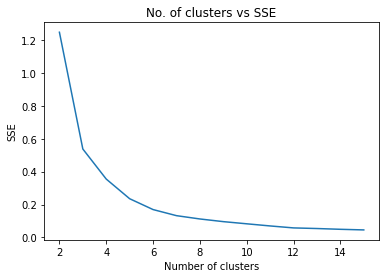

Kmeans - Mushroom
SSE for cluster 2 is 11.859924482446358
SSE for cluster 3 is 10.959405791517622
SSE for cluster 4 is 10.1777333951413
SSE for cluster 5 is 9.546833408992647
SSE for cluster 6 is 9.04379191404687
SSE for cluster 7 is 8.635239940781728
SSE for cluster 8 is 8.293174479647048
SSE for cluster 9 is 7.970436716307954
SSE for cluster 10 is 7.6529484711066775
SSE for cluster 11 is 7.398291066607505
SSE for cluster 12 is 7.132092605741979
SSE for cluster 13 is 6.889813739942599
SSE for cluster 14 is 6.651098753006179
SSE for cluster 15 is 6.478054291344132


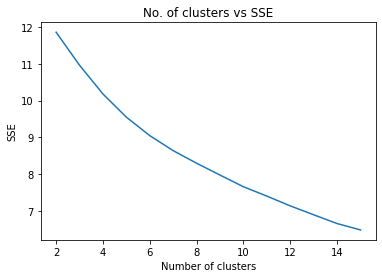

EM - Sgemm Product
Number of clusters: 2
Converged log-likelihood value is 9.475598897938895
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 3
Converged log-likelihood value is 9.726539808868447
No.of Iterations for log-likelihood to converge is 3
Number of clusters: 4
Converged log-likelihood value is 9.728784729638942
No.of Iterations for log-likelihood to converge is 5
Number of clusters: 5
Converged log-likelihood value is 9.729336457766275
No.of Iterations for log-likelihood to converge is 5
Number of clusters: 6
Converged log-likelihood value is 9.728847431695234
No.of Iterations for log-likelihood to converge is 6
Number of clusters: 7
Converged log-likelihood value is 9.75270885846472
No.of Iterations for log-likelihood to converge is 6
Number of clusters: 8
Converged log-likelihood value is 9.752843893283266
No.of Iterations for log-likelihood to converge is 6
Number of clusters: 9
Converged log-likelihood value is 9.752918526344912
No.of Iterations fo

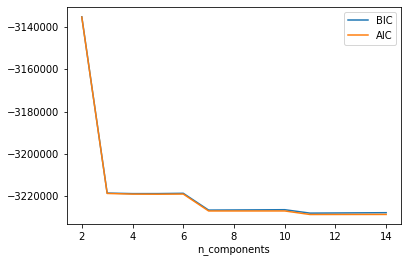

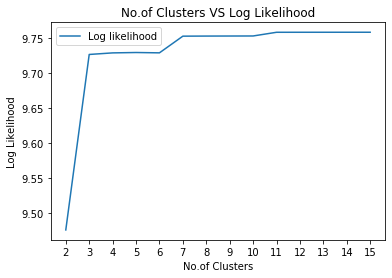

EM - Mushroom
Number of clusters: 2
Converged log-likelihood value is 32.345936472140544
No.of Iterations for log-likelihood to converge is 13
Number of clusters: 3
Converged log-likelihood value is 32.771828294633195
No.of Iterations for log-likelihood to converge is 17
Number of clusters: 4
Converged log-likelihood value is 33.40144886474136
No.of Iterations for log-likelihood to converge is 34
Number of clusters: 5
Converged log-likelihood value is 34.98400467402643
No.of Iterations for log-likelihood to converge is 32
Number of clusters: 6
Converged log-likelihood value is 34.62234049490497
No.of Iterations for log-likelihood to converge is 38
Number of clusters: 7
Converged log-likelihood value is 35.53975483251273
No.of Iterations for log-likelihood to converge is 45
Number of clusters: 8
Converged log-likelihood value is 35.436012382415605
No.of Iterations for log-likelihood to converge is 32
Number of clusters: 9
Converged log-likelihood value is 35.91974957016468
No.of Iterati

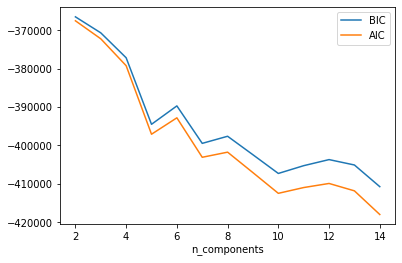

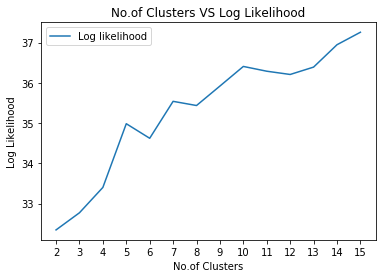

In [38]:
#Kmeans
#=======
print("Kmeans - Sgemm Product")
kmean(sgemm_train_x_transformed_ica, sgemm_train_y, sgemm_test_x_transformed_ica, sgemm_test_y, min_cluster=2, max_cluster=15)

print("Kmeans - Mushroom")
kmean(mush_train_x_transformed_ica, mush_train_y, mush_test_x_transformed_ica, mush_test_y, min_cluster=2, max_cluster=15)

#Expectation Maximization
#=========================
print("EM - Sgemm Product")
EM(sgemm_train_x_transformed_ica, sgemm_train_y, sgemm_test_x_transformed_ica, sgemm_test_y, min_cluster=2, max_cluster=15)

print("EM - Mushroom")
EM(mush_train_x_transformed_ica, mush_train_y, mush_test_x_transformed_ica, mush_test_y, min_cluster=2, max_cluster=15)

### Run Neural Networks

In [53]:
#Dataset 1 = sgemm product 
#==========================

sgemm_acc_train_ica, sgemm_cc_test_ica = cross_validation(sgemm_train_x_transformed_ica, sgemm_train_y, sgemm_test_x_transformed_ica, sgemm_test_y, 1,3, 1, sgemm_train_x_transformed_ica.shape[1],'relu','sigmoid')

print("In Sample accuracy from ANN is {0}".format(sgemm_acc_train_ica))
print("Out of Sample accuracy from ANN is {0}".format(sgemm_cc_test_ica))
print(" ")
print("Average In Sample accuracy from ANN is {0}".format(statistics.mean(sgemm_acc_train_ica)))
print("Average Out of Sample accuracy from ANN is {0}".format(statistics.mean(sgemm_cc_test_ica)))


# Dataset 2 = mushroom
#======================

mush_acc_train_ica, mush_acc_test_ica = cross_validation(mush_train_x_transformed_ica, mush_train_y, mush_test_x_transformed_ica, mush_test_y, 1,3, 1, mush_train_x_transformed_ica.shape[1],'relu','sigmoid')

print("In Sample accuracy from ANN is {0}".format(mush_acc_train_ica))
print("Out of Sample accuracy from ANN is {0}".format(mush_acc_test_ica))
print(" ")
print("Average In Sample accuracy from ANN is {0}".format(statistics.mean(mush_acc_train_ica)))
print("Average Out of Sample accuracy from ANN is {0}".format(statistics.mean(mush_acc_test_ica)))

Cross validation iteration : 1
No.of neurons in 1st hidden layer: 3
In sample confusion matrix:
[[35808  3103]
 [11410  4827]]
Out of sample confusion matrix:
[[13293  3312]
 [ 5294  1736]]
55148/55148 [==============================] - 1s 16us/step
In Sample Accuracy: 0.74
23635/23635 [==============================] - 0s 16us/step
Out of Sample Accuracy: 0.64
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 3
In sample confusion matrix:
[[35334  3690]
 [10436  5688]]
Out of sample confusion matrix:
[[13131  3661]
 [ 5124  1719]]
55148/55148 [==============================] - 1s 22us/step
In Sample Accuracy: 0.74
23635/23635 [==============================] - 0s 16us/step
Out of Sample Accuracy: 0.63
Cross validation iteration : 3
No.of neurons in 1st hidden layer: 3
In sample confusion matrix:
[[35718  3229]
 [11429  4772]]
Out of sample confusion matrix:
[[13290  3363]
 [ 5287  1695]]
55148/55148 [==============================] - 1s 15us/step
In Sample Accuracy: 0.

# Randomized Projections

In [41]:
new_dimension_sgemm = int(sgemm_train_x.shape[1]/2)
new_dimension_mush = int(mush_train_x.shape[1]/2)

#Dataset 1 = sgemm product 
#==========================
rca = GaussianRandomProjection(n_components=new_dimension_sgemm, random_state=0)
sgemm_train_x_transformed_rca_g =rca.fit_transform(sgemm_train_x)
sgemm_test_x_transformed_rca_g =rca.fit_transform(sgemm_test_x)
print("No.of features before transformation: {0}".format(sgemm_train_x.shape[1]))
print("No.of features after transformation: {0}".format(sgemm_train_x_transformed_rca_g.shape[1]))

rca = SparseRandomProjection(n_components=new_dimension_sgemm, random_state=0)
sgemm_train_x_transformed_rca_s =rca.fit_transform(sgemm_train_x)
sgemm_test_x_transformed_rca_s =rca.fit_transform(sgemm_test_x)
print("No.of features before transformation: {0}".format(sgemm_train_x.shape[1]))
print("No.of features after transformation: {0}".format(sgemm_train_x_transformed_rca_s.shape[1]))

# Dataset 2 = mushroom
#======================
rca = GaussianRandomProjection(n_components=new_dimension_mush, random_state=0)
mush_train_x_transformed_rca_g =rca.fit_transform(mush_train_x)
mush_test_x_transformed_rca_g =rca.fit_transform(mush_test_x)
print("No.of features before transformation: {0}".format(mush_train_x.shape[1]))
print("No.of features after transformation: {0}".format(mush_train_x_transformed_rca_g.shape[1]))

rca = SparseRandomProjection(n_components=new_dimension_mush, random_state=0)
mush_train_x_transformed_rca_s =rca.fit_transform(mush_train_x)
mush_test_x_transformed_rca_s =rca.fit_transform(mush_test_x)
print("No.of features before transformation: {0}".format(mush_train_x.shape[1]))
print("No.of features after transformation: {0}".format(mush_train_x_transformed_rca_s.shape[1]))


No.of features before transformation: 14
No.of features after transformation: 7
No.of features before transformation: 14
No.of features after transformation: 7
No.of features before transformation: 111
No.of features after transformation: 55
No.of features before transformation: 111
No.of features after transformation: 55


### Rerun Clustering

Kmeans - Sgemm Product
SSE for cluster 2 is 1584424.534901847
SSE for cluster 3 is 1377107.7507921362
SSE for cluster 4 is 1229852.2328970304
SSE for cluster 5 is 1125121.229608376
SSE for cluster 6 is 1037102.7730422241
SSE for cluster 7 is 975056.2418841561
SSE for cluster 8 is 928269.869604359
SSE for cluster 9 is 886265.5749926273
SSE for cluster 10 is 855242.1933586778
SSE for cluster 11 is 826028.664643451
SSE for cluster 12 is 798554.6855575431
SSE for cluster 13 is 775113.3331566975
SSE for cluster 14 is 752004.7098496074
SSE for cluster 15 is 734128.5397626372


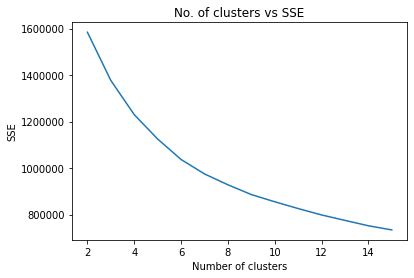

Kmeans - Mushroom
SSE for cluster 2 is 48246.11465611909
SSE for cluster 3 is 41871.20679650064
SSE for cluster 4 is 37557.703535894165
SSE for cluster 5 is 34851.3130090681
SSE for cluster 6 is 32954.36585307264
SSE for cluster 7 is 31771.363618069256
SSE for cluster 8 is 30870.89068802612
SSE for cluster 9 is 29809.623260965884
SSE for cluster 10 is 29207.83402953992
SSE for cluster 11 is 28339.84996325604
SSE for cluster 12 is 27208.56508078899
SSE for cluster 13 is 26682.04180670555
SSE for cluster 14 is 26163.637842527034
SSE for cluster 15 is 25465.999738553888


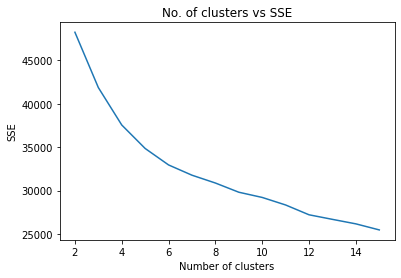

EM - Sgemm Product
Number of clusters: 2
Converged log-likelihood value is -10.423147236492316
No.of Iterations for log-likelihood to converge is 20
Number of clusters: 3
Converged log-likelihood value is -10.341656926494549
No.of Iterations for log-likelihood to converge is 25
Number of clusters: 4
Converged log-likelihood value is -10.266378417062382
No.of Iterations for log-likelihood to converge is 17
Number of clusters: 5
Converged log-likelihood value is -10.232387446037162
No.of Iterations for log-likelihood to converge is 19
Number of clusters: 6
Converged log-likelihood value is -10.18865848313463
No.of Iterations for log-likelihood to converge is 16
Number of clusters: 7
Converged log-likelihood value is -10.176074020805073
No.of Iterations for log-likelihood to converge is 16
Number of clusters: 8
Converged log-likelihood value is -10.016069570037702
No.of Iterations for log-likelihood to converge is 30
Number of clusters: 9
Converged log-likelihood value is -9.9884928701623

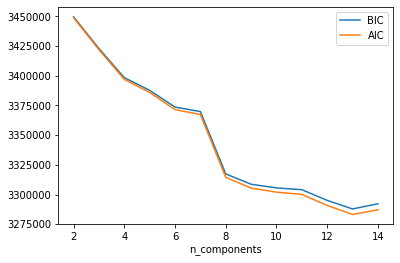

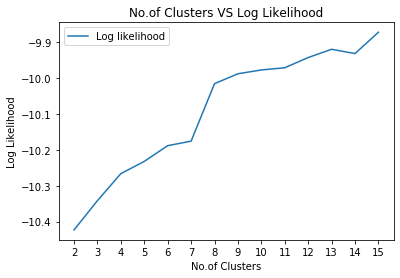

EM - Mushroom
Number of clusters: 2
Converged log-likelihood value is 38.18505739321554
No.of Iterations for log-likelihood to converge is 4
Number of clusters: 3
Converged log-likelihood value is 92.67829672063257
No.of Iterations for log-likelihood to converge is 4
Number of clusters: 4
Converged log-likelihood value is 131.01100058799014
No.of Iterations for log-likelihood to converge is 7
Number of clusters: 5
Converged log-likelihood value is 162.21098452569217
No.of Iterations for log-likelihood to converge is 5
Number of clusters: 6
Converged log-likelihood value is 159.08366597100863
No.of Iterations for log-likelihood to converge is 5
Number of clusters: 7
Converged log-likelihood value is 186.41985446918278
No.of Iterations for log-likelihood to converge is 4
Number of clusters: 8
Converged log-likelihood value is 206.60523940443872
No.of Iterations for log-likelihood to converge is 5
Number of clusters: 9
Converged log-likelihood value is 211.75319353596362
No.of Iterations 

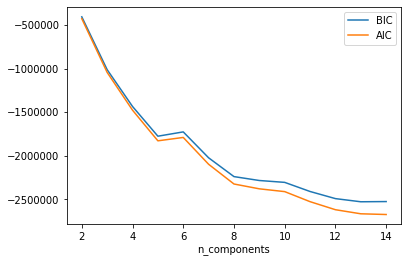

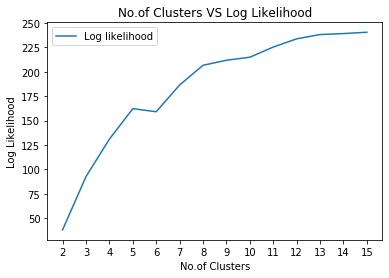

In [42]:
#Kmeans
#=======
print("Kmeans - Sgemm Product")
kmean(sgemm_train_x_transformed_rca_g, sgemm_train_y, sgemm_test_x_transformed_rca_g, sgemm_test_y, min_cluster=2, max_cluster=15)

print("Kmeans - Mushroom")
kmean(mush_train_x_transformed_rca_g, mush_train_y, mush_test_x_transformed_rca_g, mush_test_y, min_cluster=2, max_cluster=15)

#Expectation Maximization
#=========================
print("EM - Sgemm Product")
EM(sgemm_train_x_transformed_rca_g, sgemm_train_y, sgemm_test_x_transformed_rca_g, sgemm_test_y, min_cluster=2, max_cluster=15)

print("EM - Mushroom")
EM(mush_train_x_transformed_rca_g, mush_train_y, mush_test_x_transformed_rca_g, mush_test_y, min_cluster=2, max_cluster=15)

### Run Neural Networks

In [54]:
#Dataset 1 = sgemm product 
#==========================

sgemm_acc_train_rca_g, sgemm_cc_test_rca_g = cross_validation(sgemm_train_x_transformed_rca_g, sgemm_train_y, sgemm_test_x_transformed_rca_g, sgemm_test_y, 1,3, 1, sgemm_train_x_transformed_rca_g.shape[1],'relu','sigmoid')

print("In Sample accuracy from ANN is {0}".format(sgemm_acc_train_rca_g))
print("Out of Sample accuracy from ANN is {0}".format(sgemm_cc_test_rca_g))
print(" ")
print("Average In Sample accuracy from ANN is {0}".format(statistics.mean(sgemm_acc_train_rca_g)))
print("Average Out of Sample accuracy from ANN is {0}".format(statistics.mean(sgemm_cc_test_rca_g)))


# Dataset 2 = mushroom
#======================

mush_acc_train_rca_g, mush_acc_test_rca_g = cross_validation(mush_train_x_transformed_rca_g, mush_train_y, mush_test_x_transformed_rca_g, mush_test_y, 1,3, 1, mush_train_x_transformed_rca_g.shape[1],'relu','sigmoid')

print("In Sample accuracy from ANN is {0}".format(mush_acc_train_rca_g))
print("Out of Sample accuracy from ANN is {0}".format(mush_acc_test_rca_g))
print(" ")
print("Average In Sample accuracy from ANN is {0}".format(statistics.mean(mush_acc_train_rca_g)))
print("Average Out of Sample accuracy from ANN is {0}".format(statistics.mean(mush_acc_test_rca_g)))

Cross validation iteration : 1
No.of neurons in 1st hidden layer: 6
In sample confusion matrix:
[[35670  3241]
 [ 7060  9177]]
Out of sample confusion matrix:
[[15246  1359]
 [ 2978  4052]]
55148/55148 [==============================] - 1s 16us/step
In Sample Accuracy: 0.81
23635/23635 [==============================] - 0s 17us/step
Out of Sample Accuracy: 0.82
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 6
In sample confusion matrix:
[[35355  3669]
 [ 6981  9143]]
Out of sample confusion matrix:
[[15192  1600]
 [ 2973  3870]]
55148/55148 [==============================] - 1s 15us/step
In Sample Accuracy: 0.81
23635/23635 [==============================] - 0s 15us/step
Out of Sample Accuracy: 0.81
Cross validation iteration : 3
No.of neurons in 1st hidden layer: 6
In sample confusion matrix:
[[35861  3086]
 [ 7179  9022]]
Out of sample confusion matrix:
[[15291  1362]
 [ 3076  3906]]
55148/55148 [==============================] - 1s 15us/step
In Sample Accuracy: 0.

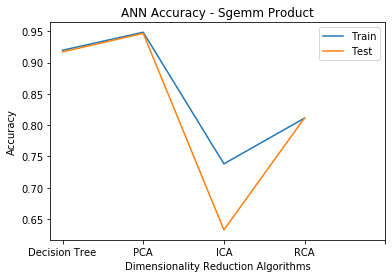

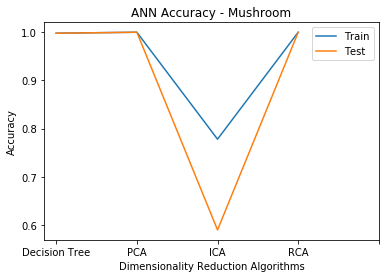

In [62]:
#Dataset 1 = sgemm product 
#==========================
nn = np.array(['Decision Tree','PCA','ICA','RCA'])
nn_train = np.array([statistics.mean(sgemm_acc_train_dt),statistics.mean(sgemm_acc_train_pca),statistics.mean(sgemm_acc_train_ica),statistics.mean(sgemm_acc_train_rca_g)])
nn_test = np.array([statistics.mean(sgemm_cc_test_dt),statistics.mean(sgemm_cc_test_pca),statistics.mean(sgemm_cc_test_ica),statistics.mean(sgemm_cc_test_rca_g)])
plt.title('ANN Accuracy - Sgemm Product')
plt.plot(nn_train, label = 'Train')
plt.plot(nn_test, label = 'Test')
plt.xticks([0,1,2,3,4], nn)
plt.xlabel('Dimensionality Reduction Algorithms')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#Dataset 2 = mushroom 
#=====================
nn = np.array(['Decision Tree','PCA','ICA','RCA'])
nn_train = np.array([statistics.mean(mush_acc_train_dt),statistics.mean(mush_acc_train_pca),statistics.mean(mush_acc_train_ica),statistics.mean(mush_acc_train_rca_g)])
nn_test = np.array([statistics.mean(mush_acc_test_dt),statistics.mean(mush_acc_test_pca),statistics.mean(mush_acc_test_ica),statistics.mean(mush_acc_test_rca_g)])
plt.title('ANN Accuracy - Mushroom')
plt.plot(nn_train, label = 'Train')
plt.plot(nn_test, label = 'Test')
plt.xticks([0,1,2,3,4], nn)
plt.xlabel('Dimensionality Reduction Algorithms')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Shape of the Cluster: (165444, 10)
ANN for original Dataset
Cross validation iteration : 1
No.of neurons in 1st hidden layer: 11
In sample confusion matrix:
[[38024   887]
 [  878 15359]]
Out of sample confusion matrix:
[[11754  4878]
 [ 4899  2104]]
55148/55148 [==============================] - 2s 28us/step
In Sample Accuracy: 0.97
23635/23635 [==============================] - 1s 28us/step
Out of Sample Accuracy: 0.59
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 11
In sample confusion matrix:
[[38105   919]
 [  883 15241]]
Out of sample confusion matrix:
[[11787  4892]
 [ 4913  2043]]
55148/55148 [==============================] - 2s 33us/step
In Sample Accuracy: 0.97
23635/23635 [==============================] - 1s 33us/step
Out of Sample Accuracy: 0.59
Cross validation iteration : 3
No.of neurons in 1st hidden layer: 11
In sample confusion matrix:
[[37851  1096]
 [  787 15414]]
Out of sample confusion matrix:
[[11679  5076]
 [ 4854  2026]]
55148/55148 [======

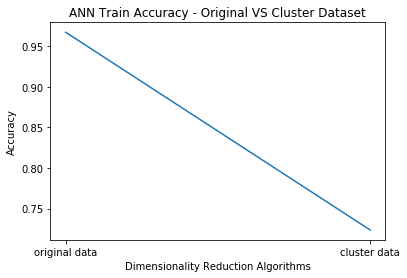

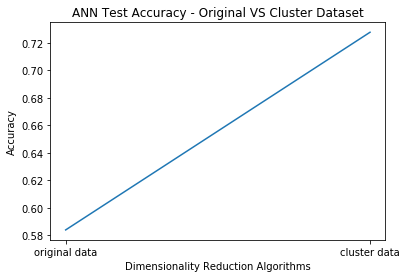

In [65]:
#Dataset 1 = sgemm product 
#==========================

k = KMeans(n_clusters=8, random_state=0).fit_predict(sgemm_train_x)
g = GaussianMixture(9, covariance_type='full', random_state=0).fit(sgemm_train_x)
g_pred = g.predict_proba(sgemm_train_x)
cluster1=pd.DataFrame(g_pred)
cluster1['k']=pd.DataFrame(k)
print('Shape of the Cluster:',cluster1.shape)

clus_xtrain, clus_xtest, clus_ytrain, clus_ytest = train_test_split(cluster1, sgemm_train_y)

# ANN for orig dataset
#=====================
print("ANN for original Dataset")
sgemm_acc_train_orig, sgemm_acc_test_orig = cross_validation(sgemm_train_x, sgemm_train_y, sgemm_test_x, sgemm_train_y, 1,3, 1, len(sgemm_train_x.columns),'relu','sigmoid')

# ANN for orig dataset
#=====================
print("ANN for cluster Dataset")
sgemm_acc_train, sgemm_acc_test = cross_validation(clus_xtrain, clus_ytrain, clus_xtest, clus_ytest, 1,3, 1, len(clus_xtrain.columns),'relu','sigmoid')


x = np.array(["original data","cluster data"])
cv_acc = np.array([statistics.mean(sgemm_acc_train_orig),statistics.mean(sgemm_acc_train)])
plt.title("ANN Train Accuracy - Original VS Cluster Dataset")
plt.plot(cv_acc)
plt.xticks([0,1],x)
plt.xlabel('Dimensionality Reduction Algorithms')
plt.ylabel('Accuracy')
plt.show()

x = np.array(["original data","cluster data"])
cv_acc = np.array([statistics.mean(sgemm_acc_test_orig),statistics.mean(sgemm_acc_test)])
plt.title("ANN Test Accuracy - Original VS Cluster Dataset")
plt.plot(cv_acc)
plt.xticks([0,1],x)
plt.xlabel('Dimensionality Reduction Algorithms')
plt.ylabel('Accuracy')
plt.show()

Shape of the Cluster: (5686, 11)
ANN for original Dataset
Cross validation iteration : 1
No.of neurons in 1st hidden layer: 75
In sample confusion matrix:
[[986   0]
 [  0 909]]
Out of sample confusion matrix:
[[216 211]
 [207 178]]
1895/1895 [==============================] - 0s 42us/step
In Sample Accuracy: 1.00
812/812 [==============================] - 0s 23us/step
Out of Sample Accuracy: 0.49
Cross validation iteration : 2
No.of neurons in 1st hidden layer: 75
In sample confusion matrix:
[[980   0]
 [  0 915]]
Out of sample confusion matrix:
[[216 196]
 [213 188]]
1895/1895 [==============================] - 0s 55us/step
In Sample Accuracy: 1.00
813/813 [==============================] - 0s 52us/step
Out of Sample Accuracy: 0.50
Cross validation iteration : 3
No.of neurons in 1st hidden layer: 75
In sample confusion matrix:
[[970   0]
 [  0 926]]
Out of sample confusion matrix:
[[208 224]
 [212 169]]
1896/1896 [==============================] - 0s 52us/step
In Sample Accuracy: 1.0

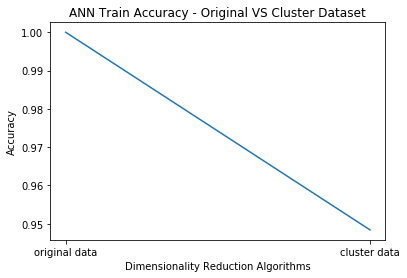

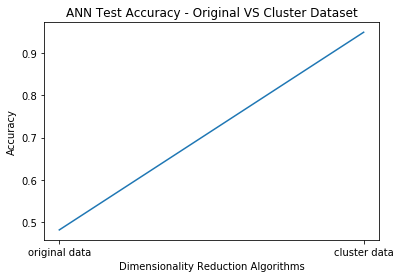

In [67]:
#Dataset 2 = mushroom 
#=====================

k = KMeans(n_clusters=6, random_state=0).fit_predict(mush_train_x)
g = GaussianMixture(10, covariance_type='full', random_state=0).fit(mush_train_x)
g_pred = g.predict_proba(mush_train_x)
cluster1=pd.DataFrame(g_pred)
cluster1['k']=pd.DataFrame(k)
print('Shape of the Cluster:',cluster1.shape)

clus_xtrain, clus_xtest, clus_ytrain, clus_ytest = train_test_split(cluster1, mush_train_y)

# ANN for orig dataset
#=====================
print("ANN for original Dataset")
mush_acc_train_orig, mush_acc_test_orig = cross_validation(mush_train_x, mush_train_y, mush_test_x, mush_train_y, 1,3, 1, len(mush_train_x.columns),'relu','sigmoid')

# ANN for orig dataset
#=====================
print("ANN for cluster Dataset")
mush_acc_train, mush_acc_test = cross_validation(clus_xtrain, clus_ytrain, clus_xtest, clus_ytest, 1,3, 1, len(clus_xtrain.columns),'relu','sigmoid')


x = np.array(["original data","cluster data"])
cv_acc = np.array([statistics.mean(mush_acc_train_orig),statistics.mean(mush_acc_train)])
plt.title("ANN Train Accuracy - Original VS Cluster Dataset")
plt.plot(cv_acc)
plt.xticks([0,1],x)
plt.xlabel('Dimensionality Reduction Algorithms')
plt.ylabel('Accuracy')
plt.show()

x = np.array(["original data","cluster data"])
cv_acc = np.array([statistics.mean(mush_acc_test_orig),statistics.mean(mush_acc_test)])
plt.title("ANN Test Accuracy - Original VS Cluster Dataset")
plt.plot(cv_acc)
plt.xticks([0,1],x)
plt.xlabel('Dimensionality Reduction Algorithms')
plt.ylabel('Accuracy')
plt.show()